# Part I :
## Contexte de l’analyse

Réaliser:
- un clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes
- une prédiction des profils dont le métier n'est pas labellisé


## Données
data.csv contient 6 variables : 
    - 'Entreprise' correspond à une liste d'entreprises fictive
    - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
    - 'Technologies' correspond aux compétences maîtrisées par le profil
    - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
    - 'Experience' correspond au nombre d'années d'expériences
    - 'Ville' correspond au lieu de travail
   

In [186]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np
import re
import sklearn as sk
import seaborn as sb
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

### 1) Importer le tableau de données dans un dataframe 

In [2]:
# Import du dataframe "data.csv"
df = pd.read_csv('data.csv')

In [3]:
df.head(5)

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,"1,5",Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


### 2) Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs manquantes? 

In [4]:
print('il y a ' +  str(df.shape[0]) +' observations dans ce dataset')

il y a 9582 observations dans ce dataset


In [5]:
# missing values by feature
df.isna().sum()

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      94
Ville            0
dtype: int64

## 3) Réaliser l'imputation des valeurs manquantes pour la variable "Experience" avec : 
- la valeur médiane pour les data scientists
- la valeur moyenne pour les data engineers

In [6]:
df['Experience'] = df['Experience'].replace(regex=r',', value='.')
df['Experience'] = df['Experience'].astype('float32')

df.groupby(['Metier'])['Experience'].mean()

Metier
Data architecte        3.000476
Data engineer          2.984959
Data scientist         2.243282
Lead data scientist    3.965261
Name: Experience, dtype: float32

In [7]:
df.groupby(['Metier'])['Experience'].median()

Metier
Data architecte        2.5
Data engineer          2.5
Data scientist         2.0
Lead data scientist    3.5
Name: Experience, dtype: float32

In [8]:
Index_to_replace = df[(df['Metier']=='Data engineer') & (df['Experience'].isna())].index.values.astype(int);
df['Experience'].iloc[Index_to_replace] = 2.5;

/tmp/ipykernel_22737/3451940077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Experience'].iloc[Index_to_replace] = 2.5;


In [9]:
Index_to_replace = df[(df['Metier']=='Data scientist') & (df['Experience'].isna())].index.values.astype(int);
df['Experience'].iloc[Index_to_replace] =  2.243282;

/tmp/ipykernel_22737/1306550804.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Experience'].iloc[Index_to_replace] =  2.243282;


In [10]:
# verify
df.isna().sum()
# there are still missing values ! 

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience      42
Ville            0
dtype: int64

In [11]:
Index_to_replace = df[(df['Metier']=='Data architecte') & (df['Experience'].isna())].index.values.astype(int)
df['Experience'].iloc[Index_to_replace] =  2.5;

Index_to_replace = df[(df['Metier']=='Lead data scientist') & (df['Experience'].isna())].index.values.astype(int)
df['Experience'].iloc[Index_to_replace] =  2.5;

In [12]:
#verify that we did the correct imputation
df.isna().sum()

Entreprise      17
Metier          19
Technologies     0
Diplome          0
Experience       0
Ville            0
dtype: int64

### 4) Combien d'années d'expériences ont, en moyenne, chacun des profils : le data scientist, le lead data scientist et le data engineer en moyenne?

Data architecte:        3.000476

Data engineer:          2.984959

Data scientist:         2.243282

Lead data scientist:    3.965261

### 5) Faire la représentation graphique de votre choix afin de comparer le nombre moyen d'années d'expériences pour chaque métier

<AxesSubplot: xlabel='Metier'>

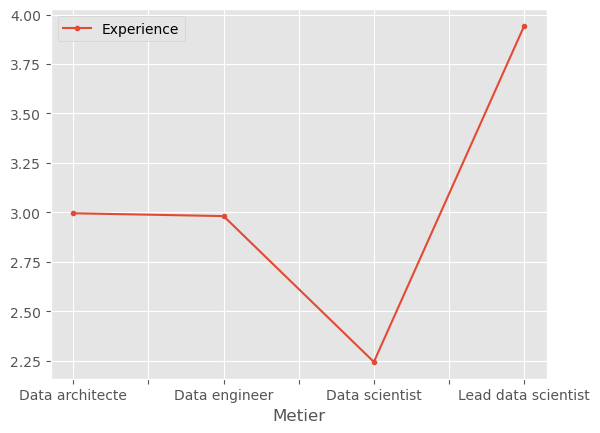

In [13]:
df.groupby('Metier')['Experience'].mean().plot(legend=True, **{'marker': '.'})

### 6) Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités: débutant, confirmé, avancé et expert
- Veuillez expliquer votre choix du règle de transformation.  

<AxesSubplot: >

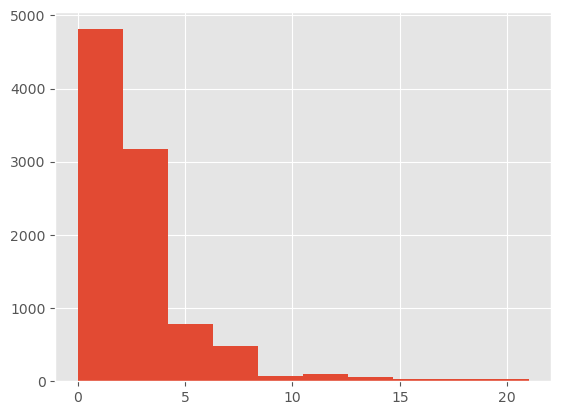

In [14]:
df['Experience'].hist()

#0-2: debutant
#2-4: confirmé
#4-6: avancé
#6 et+: expert

In [15]:
def Transform_in_a_cat_variable(x):
    if x['Experience'] <= 2:
        return  0
    elif (x['Experience'] > 2) and (x['Experience'] <= 4):
        return   1
    elif (x['Experience'] > 4) and (x['Experience'] <= 6):
        return 2
    elif (x['Experience'] > 6):
        return 3
    else:
        return  -1

In [16]:
df['Exp_label'] = df.apply(Transform_in_a_cat_variable, axis=1)
df

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.000000,Paris,0
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.000000,Marseille,1
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.000000,Nantes,1
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.500000,Marseille,0
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.243282,Bordeaux,1
...,...,...,...,...,...,...,...
9577,Massachusetts General Hospital(MGH),Data scientist,C++/R/Python/Matlab/Matplotlib,Master,1.500000,Lyon,0
9578,Charles River Analytics,Data scientist,Excel/Python/Matlab/R/machine learning/anglais,Master,11.000000,Toulouse,3
9579,Ball Aerospace,Data scientist,R/machine learning/Excel/VBA,Master,1.000000,Paris,0
9580,Takeda Pharmaceutical,Data scientist,Python/Pyspark/machine learning/Microsoft Azure,Master,17.000000,Rennes,3


### 7) Quelles sont les 5 technologies les plus utilisées? Faites un graphique

In [17]:
technologies_array = df['Technologies'].to_numpy()
D = {}

for u in technologies_array:
    tech_temp = u.split('/')
    for name_tech in tech_temp:
        if name_tech in list(D.keys()):
            D[name_tech] = D[name_tech] + 1
        else:
            D[name_tech] =  1

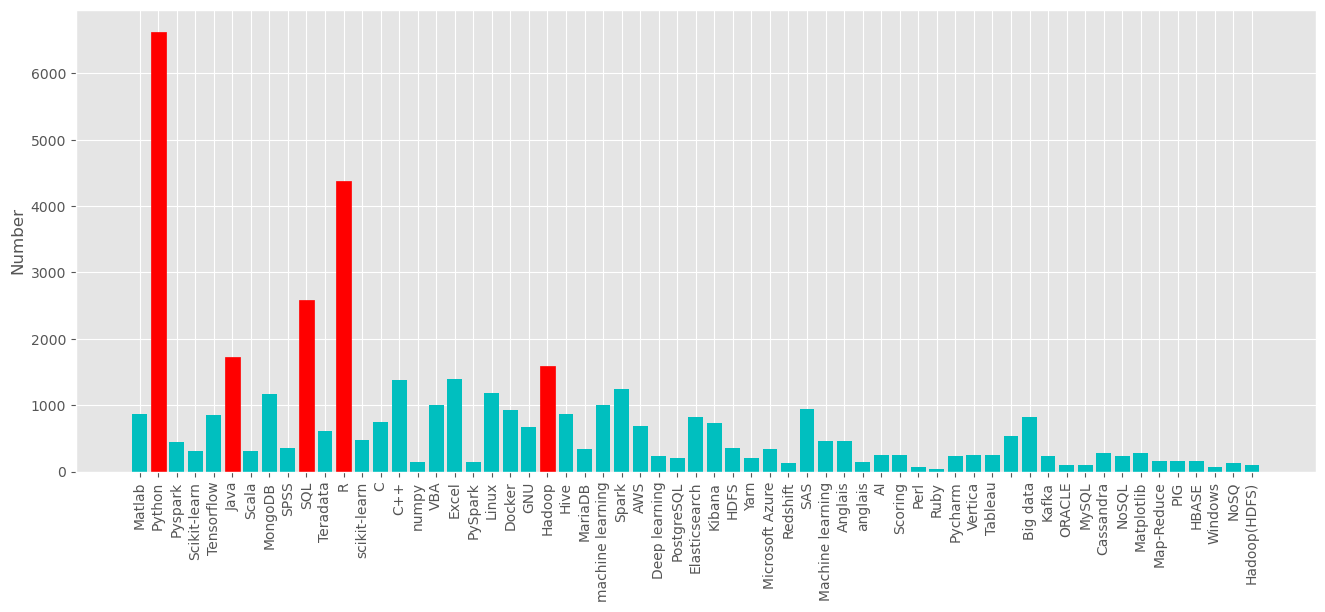

In [18]:
names_tech = list(D.keys())
num = list(D.values())
fig, ax = plt.subplots(figsize=(16, 6))
bar_list = plt.bar(range(len(names_tech)), num, tick_label=names_tech, **{'color':'c'})
bar_list[1].set_color('r')
bar_list[11].set_color('r')
bar_list[9].set_color('r')
bar_list[5].set_color('r')
bar_list[22].set_color('r')
ax.set_ylabel('Number')
plt.xticks(rotation = 90) 
plt.show()

### 8) Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître 2 clusters que vous jugerez pertinents. Donnez les caractéristiques de chacun des clusters.
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

In [19]:
def Transform_diploma_in_a_cat_variable(x):
    if x['Diplome'] == 'No diploma':
        return  0
    elif x['Diplome'] == 'Bachelor':
        return   1
    elif x['Diplome'] == 'Master':
        return 2
    elif (x['Diplome'] == 'Phd'):
        return 3
    else:
        return  -1

In [20]:
df['Diploma_cat'] = df.apply(Transform_diploma_in_a_cat_variable, axis = 1)

In [21]:
df

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label,Diploma_cat
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.000000,Paris,0,2
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.000000,Marseille,1,2
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.000000,Nantes,1,2
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.500000,Marseille,0,2
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.243282,Bordeaux,1,3
...,...,...,...,...,...,...,...,...
9577,Massachusetts General Hospital(MGH),Data scientist,C++/R/Python/Matlab/Matplotlib,Master,1.500000,Lyon,0,2
9578,Charles River Analytics,Data scientist,Excel/Python/Matlab/R/machine learning/anglais,Master,11.000000,Toulouse,3,2
9579,Ball Aerospace,Data scientist,R/machine learning/Excel/VBA,Master,1.000000,Paris,0,2
9580,Takeda Pharmaceutical,Data scientist,Python/Pyspark/machine learning/Microsoft Azure,Master,17.000000,Rennes,3,2


In [22]:
list_techs = list(D.keys())
for tech in list_techs:
    df[tech] = 0

In [27]:
def is_in(str_techs, tech):
    list_techs_local = str_techs.split('/')
    if tech in list_techs_local:
        return 1.0
    else:
        return 0.0

In [29]:
for u in list_techs:
    df[u] = df["Technologies"].apply(lambda x : is_in(x, u))


In [33]:
df.head(5)

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Exp_label,Diploma_cat,Matlab,Python,...,MySQL,Cassandra,NoSQL,Matplotlib,Map-Reduce,PIG,HBASE,Windows,NoSQ,Hadoop(HDFS)
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.000000,Paris,0,2,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.000000,Marseille,1,2,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.000000,Nantes,1,2,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.500000,Marseille,0,2,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.243282,Bordeaux,1,3,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
df.columns

Index(['Entreprise', 'Metier', 'Technologies', 'Diplome', 'Experience',
       'Ville', 'Exp_label', 'Diploma_cat', 'Matlab', 'Python', 'Pyspark',
       'Scikit-learn', 'Tensorflow', 'Java', 'Scala', 'MongoDB', 'SPSS', 'SQL',
       'Teradata', 'R', 'scikit-learn', 'C', 'C++', 'numpy', 'VBA', 'Excel',
       'PySpark', 'Linux', 'Docker', 'GNU', 'Hadoop', 'Hive', 'MariaDB',
       'machine learning', 'Spark', 'AWS', 'Deep learning', 'PostgreSQL',
       'Elasticsearch', 'Kibana', 'HDFS', 'Yarn', 'Microsoft Azure',
       'Redshift', 'SAS', 'Machine learning', 'Anglais', 'anglais', 'AI',
       'Scoring', 'Perl', 'Ruby', 'Pycharm', 'Vertica', 'Tableau', '',
       'Big data', 'Kafka', 'ORACLE', 'MySQL', 'Cassandra', 'NoSQL',
       'Matplotlib', 'Map-Reduce', 'PIG', 'HBASE', 'Windows', 'NoSQ',
       'Hadoop(HDFS)'],
      dtype='object')

In [39]:
features = ['Exp_label', 'Diploma_cat', 'Matlab', 'Python', 'Pyspark',
       'Scikit-learn', 'Tensorflow', 'Java', 'Scala', 'MongoDB', 'SPSS', 'SQL',
       'Teradata', 'R', 'scikit-learn', 'C', 'C++', 'numpy', 'VBA', 'Excel',
       'PySpark', 'Linux', 'Docker', 'GNU', 'Hadoop', 'Hive', 'MariaDB',
       'machine learning', 'Spark', 'AWS', 'Deep learning', 'PostgreSQL',
       'Elasticsearch', 'Kibana', 'HDFS', 'Yarn', 'Microsoft Azure',
       'Redshift', 'SAS', 'Machine learning', 'Anglais', 'anglais', 'AI',
       'Scoring', 'Perl', 'Ruby', 'Pycharm', 'Vertica', 'Tableau', '',
       'Big data', 'Kafka', 'ORACLE', 'MySQL', 'Cassandra', 'NoSQL',
       'Matplotlib', 'Map-Reduce', 'PIG', 'HBASE', 'Windows', 'NoSQ',
       'Hadoop(HDFS)']
km = KMeans(n_clusters=2)
km.fit(df[features])

KMeans(n_clusters=2)

In [41]:
centers = km.cluster_centers_

In [123]:
first_clust = np.zeros(len(features))
sec_clust = np.zeros(len(features))

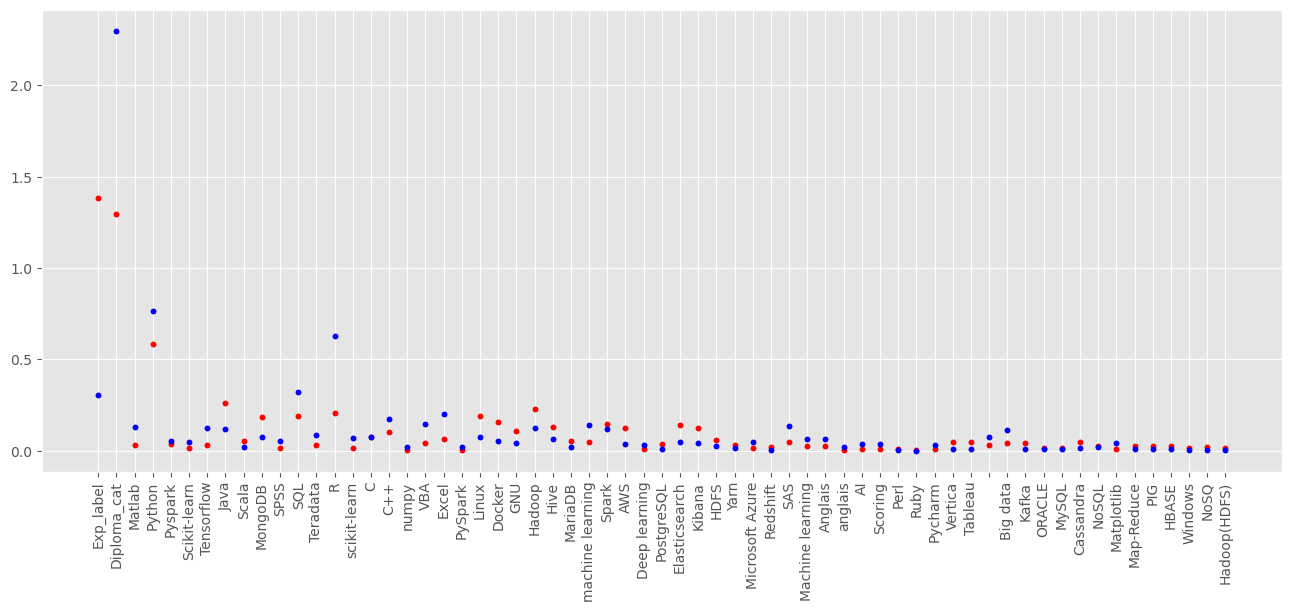

In [57]:
fig, ax = plt.subplots(figsize=(16, 6))
for ind, u in enumerate(centers[0]):
    ax.plot([ind, ind], [centers[0][ind],centers[0][ind]] ,'r.')

for ind, u in enumerate(centers[1]):
    ax.plot([ind, ind], [centers[1][ind],centers[1][ind]] ,'b.')

ax.set_xticks(np.arange(len(features)));
ax.set_xticklabels(features, rotation = 90);   
    

In [109]:
def Transform_metier_in_data1_or_info0(x):
    if (x['Metier'] == 'Data scientist') or  (x['Metier']== 'Lead data scientist'):
        return  1
    elif (x['Metier'] == 'Data engineer') or  (x['Metier']== 'Data architecte'):
        return   0
    else:
        return -1

In [110]:
df['Data1_Info0'] = df.apply(Transform_metier_in_data1_or_info0, axis=1)

In [105]:
classification = []
for i in range(len(centers[0])):
    classification.append((centers[0][i] > centers[1][i])*1.0)

In [106]:
arr_feat = df[features].to_numpy()
list_clust = []
for arr in arr_feat:
    if np.sum((arr - centers[0])**2) < np.sum((arr - centers[1])**2):
        list_clust.append(0)
    else:
        list_clust.append(1)

In [107]:
df['clust'] = list_clust

In [122]:
prec = 100*(df['Data1_Info0'] == df['clust']).sum()/len(df)
print('The prediction is accurate at ' + str(round(prec,1)) + '% ')

The prediction is accurate at 73.8% 


### 9) Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

In [158]:
def is_in_v2(met_temp, list_metiers):
    if met_temp in list_metiers:
        return 1.0
    else:
        return 0.0

In [162]:
list_metiers = ['Data scientist', 'Data architecte', 'Lead data scientist', 'Data engineer']
for u in list_metiers:
    df[u] = df["Metier"].apply(lambda x : is_in_v2(x, [u]))


In [167]:
X = df[features]
y = df[list_metiers]

In [173]:
index_train   = df[~df['Metier'].isna()].index
index_test    = df[df['Metier'].isna()].index

In [178]:
X_train = X.iloc[index_train]
y_train = y.iloc[index_train]

X_test  = X.iloc[index_test]
y_test  = y.iloc[index_test]

In [197]:
rfc=RandomForestClassifier(random_state=9)
param_grid = { 
    'n_estimators': [5, 10, 50, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5, scoring= 'accuracy');
CV_rfc.fit(X_train, y_train);

/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past b

/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past b

/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past b

/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past b

/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past b

/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past b

/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past b

/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past b

/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past b

/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past b

/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/home/jacques/Programmes/Anaconda3/envs/kaggle_env/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past b

In [198]:
y_pred = CV_rfc.best_estimator_.predict(X_test)

In [199]:
y_pred   # ['Data scientist', 'Data architecte', 'Lead data scientist', 'Data engineer']

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [200]:
CV_rfc.best_score_

0.8191954082067859

In [205]:
X_test.iloc[1].head(60)

Exp_label           3.0
Diploma_cat         2.0
Matlab              0.0
Python              1.0
Pyspark             0.0
Scikit-learn        0.0
Tensorflow          0.0
Java                0.0
Scala               0.0
MongoDB             0.0
SPSS                0.0
SQL                 0.0
Teradata            0.0
R                   1.0
scikit-learn        0.0
C                   0.0
C++                 0.0
numpy               0.0
VBA                 1.0
Excel               1.0
PySpark             0.0
Linux               0.0
Docker              0.0
GNU                 0.0
Hadoop              0.0
Hive                0.0
MariaDB             0.0
machine learning    0.0
Spark               0.0
AWS                 0.0
Deep learning       0.0
PostgreSQL          0.0
Elasticsearch       0.0
Kibana              0.0
HDFS                0.0
Yarn                0.0
Microsoft Azure     0.0
Redshift            0.0
SAS                 0.0
Machine learning    0.0
Anglais             0.0
anglais         

In [206]:
X_test.iloc[2].head(60)

Exp_label           0.0
Diploma_cat         2.0
Matlab              0.0
Python              1.0
Pyspark             0.0
Scikit-learn        0.0
Tensorflow          0.0
Java                1.0
Scala               0.0
MongoDB             0.0
SPSS                0.0
SQL                 0.0
Teradata            0.0
R                   1.0
scikit-learn        0.0
C                   1.0
C++                 1.0
numpy               0.0
VBA                 0.0
Excel               0.0
PySpark             0.0
Linux               0.0
Docker              0.0
GNU                 0.0
Hadoop              0.0
Hive                0.0
MariaDB             0.0
machine learning    0.0
Spark               0.0
AWS                 0.0
Deep learning       0.0
PostgreSQL          0.0
Elasticsearch       0.0
Kibana              0.0
HDFS                0.0
Yarn                0.0
Microsoft Azure     0.0
Redshift            0.0
SAS                 0.0
Machine learning    0.0
Anglais             0.0
anglais         

In [207]:
X_test.iloc[3].head(60)

Exp_label           0.0
Diploma_cat         3.0
Matlab              0.0
Python              1.0
Pyspark             0.0
Scikit-learn        0.0
Tensorflow          1.0
Java                0.0
Scala               0.0
MongoDB             0.0
SPSS                0.0
SQL                 0.0
Teradata            0.0
R                   1.0
scikit-learn        1.0
C                   0.0
C++                 0.0
numpy               0.0
VBA                 0.0
Excel               0.0
PySpark             0.0
Linux               0.0
Docker              0.0
GNU                 0.0
Hadoop              0.0
Hive                0.0
MariaDB             0.0
machine learning    0.0
Spark               0.0
AWS                 0.0
Deep learning       1.0
PostgreSQL          0.0
Elasticsearch       0.0
Kibana              0.0
HDFS                0.0
Yarn                0.0
Microsoft Azure     0.0
Redshift            0.0
SAS                 0.0
Machine learning    0.0
Anglais             0.0
anglais         